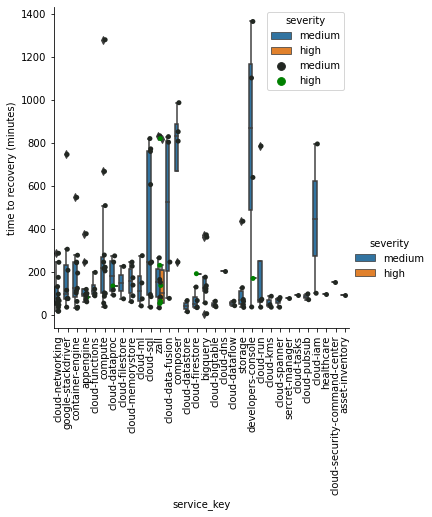

                  begin               created                 end  \
0   2021-02-24 17:04:24  2021-02-24T17:10:12Z 2021-02-24 17:21:14   
1   2021-02-24 16:32:46  2021-02-24T16:32:51Z 2021-02-24 17:19:30   
2   2021-02-24 16:09:33  2021-02-24T16:39:30Z 2021-02-24 17:24:50   
3   2021-02-19 13:47:53  2021-02-19T13:50:30Z 2021-02-19 22:54:24   
4   2021-02-18 22:31:23  2021-02-18T22:46:21Z 2021-02-19 00:11:05   
..                  ...                   ...                 ...   
159 2020-03-26 23:50:00  2020-03-27T00:46:28Z 2020-03-27 01:04:00   
160 2020-03-26 23:14:54  2020-03-27T00:23:36Z 2020-03-27 12:55:01   
161 2020-03-26 15:18:17  2020-03-26T16:08:20Z 2020-03-26 16:21:39   
162 2020-03-13 00:37:56  2020-03-13T00:54:40Z 2020-03-13 01:19:44   
163 2020-03-08 11:29:19  2020-03-08T12:33:34Z 2020-03-08 17:30:35   

                                         external_desc  \
0        Cloud Armor Configuration Updates Are Delayed   
1    External HTTP(S) Load Balancers can't be creat... 

In [1]:
import json
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

google_cloud_status_url = 'https://status.cloud.google.com/incidents.json'

response = json.loads(requests.get(google_cloud_status_url).text)

df = pd.read_json(google_cloud_status_url)

# remove the 'support' service_key as it's not relevant and skews the data
df = df[df.service_key != 'support']

df['cloud_provider'] = 'gcp'
df['begin'] = pd.to_datetime(df['begin'], format="%Y-%m-%dT%H:%M:%SZ")
df['end'] = pd.to_datetime(df['end'], format="%Y-%m-%dT%H:%M:%SZ")
df['duration'] = df['end'] - df['begin']
df['time_to_recovery'] = pd.to_numeric(df['duration'])\
                            .apply(lambda s: s / (10 ** 9) / 60)\
                            .astype(int)

# grouping the dataset to perform aggregation functions
dfGroupedByServiceKeyAndSeverity = df \
                .groupby(['service_key', 'severity']) \
                .agg(
                    min_time_to_recovery=pd.NamedAgg(column="time_to_recovery", aggfunc="min"),
                    max_time_to_recovery=pd.NamedAgg(column="time_to_recovery", aggfunc="max"),
                    avg_time_to_recovery=pd.NamedAgg(column="time_to_recovery", aggfunc="mean"),
                    severity_count=pd.NamedAgg(column="severity", aggfunc="count"),
                ) \
                .astype(int) \
                .sort_values(by=['avg_time_to_recovery'], ascending=False)

# plot the the dataset

ax = sns.catplot(
    data=df,
    x='service_key', y='time_to_recovery',
    kind='box', hue='severity'
)

ax = sns.stripplot(
    data=df,
    x='service_key', y='time_to_recovery',
    hue='severity', color='green'
)
ax.set(ylabel='time to recovery (minutes)')

plt.xticks(rotation=90)
plt.show()

print(df)
print(dfGroupedByServiceKeyAndSeverity)
